In [1]:
import GPy
from matter_multi_fidelity_emu.non_linear_multi_fidelity_models import multi_information_sources as miso
from matter_multi_fidelity_emu.non_linear_multi_fidelity_models import non_linear_multi_fidelity_model as nmf


from emukit.multi_fidelity.convert_lists_to_array import (
    convert_y_list_to_array,
    convert_xy_lists_to_arrays,
    convert_x_list_to_array,
)


import numpy as np
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
optimization_restarts=30
n_samples=100

In [4]:
# Too hard, not working
# def f(x1, x2):
#     return (1 - x1)**2 + 100 * (x2 - x1**2)**2

# def IS1(x1, x2, u = 1):
#     return f(x1, x2) + u * np.random.randn(*(x1.shape))

# def IS2(x1, x2, v = 1):
#     return f(x1, x2) + v * np.sin(10 * x1 + 5 * x2)


In [10]:
# large slope is to make sure IS is just adding some fluctuations to the true
def f(x1, x2):
    return 12 * x1 +  20 * x2

def IS1(x1, x2, u = 3):
    return f(x1, x2) + u * np.random.randn(*(x1.shape))

def IS2(x1, x2, v = 3):
#     return f(x1, x2) + v * np.sin(10 * x1 + 5 * x2)
    return f(x1, x2) + v * np.cos(5 * x1 + 10 * x2)

In [11]:
n_IS = 2

# train IS
X = np.pi * np.random.rand(50, 2) - 1
IS1_train = IS1(X[:, [0]], X[:, [1]])
IS2_train = IS2(X[:, [0]], X[:, [1]])

# train true
n_true = 10
f_train = f(X[:n_true, [0]], X[:n_true, [1]])

X_train = [X[:n_true], X, X]
Y_train = [f_train, IS1_train, IS2_train]

# make GP non linear kernel
base_kernel_1 = GPy.kern.RBF
kernels = miso.make_non_linear_kernels(
    base_kernel_1, n_IS, n_input_dims=2, ARD=True, n_output_dim=1,
)  # -1 for the multi-fidelity labels

X_init, Y_init = convert_xy_lists_to_arrays(X_train, Y_train)

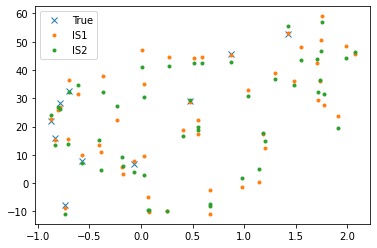

In [12]:
plt.plot(X[:n_true, [0]], f_train, ls="", marker="x", label="True")
plt.plot(X[:, [0]], IS1_train, ls="", marker=".", label="IS1")
plt.plot(X[:, [0]], IS2_train, ls="", marker=".", label="IS2")
plt.legend()

In [13]:
# model training
nargp_miso = miso.NonLinearMultiInformationModel(X_init, Y_init, n_IS=2, kernels=kernels, n_samples=n_samples, optimization_restarts=optimization_restarts)

nargp_miso.optimize()

X_pred = np.concatenate([X, np.ones((X.shape[0], 1),)], axis=1)

mean, variance = nargp_miso.predict(X_pred)

f_pred = f(X[:, [0]], X[:, [1]])

error = np.abs(1 - mean / f_pred)

 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


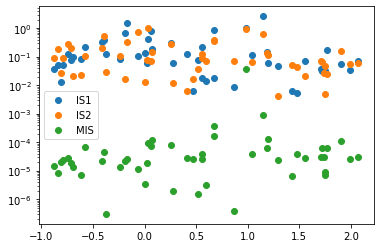

In [14]:
plt.semilogy(X[:, 0], np.abs(1 - f_pred / IS1_train), ls="", marker="o", label="IS1")
plt.semilogy(X[:, 0], np.abs(1 - f_pred / IS2_train), ls="", marker="o", label="IS2")
plt.semilogy(X[:, 0], error, ls="", marker="o", label="MIS")
plt.legend()

## Oridinary NARGP

In [15]:
X_train = [X, X[:n_true]]
Y_train = [IS1_train, f_train]

# make GP non linear kernel
base_kernel_1 = GPy.kern.RBF
kernels = nmf.make_non_linear_kernels(
    base_kernel_1, 2, n_input_dims=2, ARD=True, n_output_dim=1,
)  # -1 for the multi-fidelity labels

X_init, Y_init = convert_xy_lists_to_arrays(X_train, Y_train)

In [16]:
nargp = nmf.NonLinearMultiFidelityModel(X_init, Y_init, n_fidelities=2, kernels=kernels, n_samples=n_samples, optimization_restarts=optimization_restarts)

nargp.optimize()

mean_mf, variance_mf = nargp.predict(X_pred)

error_mf = np.abs(1 - mean_mf / f_pred)

 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


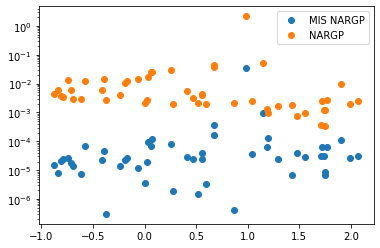

In [17]:
plt.semilogy(X[:, 0], error, ls="", marker="o", label="MIS NARGP")
plt.semilogy(X[:, 0], error_mf, ls="", marker="o", label="NARGP")
plt.legend()

In [18]:
np.nanmedian(error / error_mf)

0.005534027416026186

## Part of the IS is correct, part is more biased

In [276]:
def f(x1, x2):
    return 2 * x1 +  4 * x2

def IS1(x1, x2, u = 1, v = 10):
    return (np.heaviside(x1, 0) *  f(x1, x2) + u * np.cos(5 * x1 + 10 * x2)) + (
        np.heaviside(-x1, 0) *  f(x1, x2) + v * np.random.randn(*(x1.shape))
    )

def IS2(x1, x2, u = 1, v = 10):
#     return f(x1, x2) + v * np.sin(10 * x1 + 5 * x2)
    return (np.heaviside(x1, 0) * f(x1, x2) + u * np.random.randn(*(x1.shape))) + (
        np.heaviside(-x1, 0) * f(x1, x2) + v * np.cos(5 * x1 + 10 * x2)
    )

In [277]:
n_IS = 2

# train IS
X = np.pi * np.random.rand(50, 2) - 1
IS1_train = IS1(X[:, [0]], X[:, [1]])
IS2_train = IS2(X[:, [0]], X[:, [1]])

# train true
n_true = 10
f_train = f(X[:n_true, [0]], X[:n_true, [1]])

X_train = [X[:n_true], X, X]
Y_train = [f_train, IS1_train, IS2_train]

# make GP non linear kernel
base_kernel_1 = GPy.kern.RBF
kernels = miso.make_non_linear_kernels(
    base_kernel_1, n_IS, n_input_dims=2, ARD=True, n_output_dim=1,
)  # -1 for the multi-fidelity labels

X_init, Y_init = convert_xy_lists_to_arrays(X_train, Y_train)

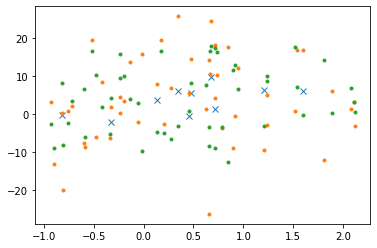

In [278]:
plt.plot(X[:n_true, [0]], f_train, ls="", marker="x")
plt.plot(X[:, [0]], IS1_train, ls="", marker=".")
plt.plot(X[:, [0]], IS2_train, ls="", marker=".")

In [279]:
nargp_miso = miso.NonLinearMultiInformationModel(X_init, Y_init, n_IS=2, kernels=kernels, n_samples=n_samples, optimization_restarts=optimization_restarts)

nargp_miso.optimize()

X_pred = np.concatenate([X, np.ones((X.shape[0], 1),)], axis=1)

mean, variance = nargp_miso.predict(X_pred)

f_pred = f(X[:, [0]], X[:, [1]])

error = np.abs(1 - mean / f_pred)

 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


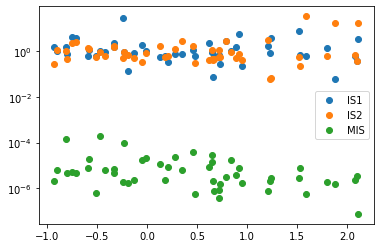

In [280]:
plt.semilogy(X[:, 0], np.abs(1 - f_pred / IS1_train), ls="", marker="o", label="IS1")
plt.semilogy(X[:, 0], np.abs(1 - f_pred / IS2_train), ls="", marker="o", label="IS2")
plt.semilogy(X[:, 0], error, ls="", marker="o", label="MIS")
plt.legend()

Ordinary NARGP

In [281]:
X_train = [X, X[:n_true]]
Y_train = [IS1_train, f_train]

# make GP non linear kernel
base_kernel_1 = GPy.kern.RBF
kernels = nmf.make_non_linear_kernels(
    base_kernel_1, 2, n_input_dims=2, ARD=True, n_output_dim=1,
)  # -1 for the multi-fidelity labels

X_init, Y_init = convert_xy_lists_to_arrays(X_train, Y_train)

In [282]:
nargp = nmf.NonLinearMultiFidelityModel(X_init, Y_init, n_fidelities=2, kernels=kernels, n_samples=n_samples, optimization_restarts=optimization_restarts)

nargp.optimize()

mean_mf, variance_mf = nargp.predict(X_pred)

error_mf = np.abs(1 - mean_mf / f_pred)

 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Warning - optimization restart 13/30 failed
Warning - optimization restart 19/30 failed
Warning - optimization restart 21/30 failed
Warning - optimization restart 26/30 failed
Warning - optimization restart 29/30 failed


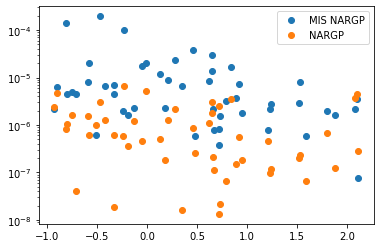

In [283]:
plt.semilogy(X[:, 0], error, ls="", marker="o", label="MIS NARGP")
plt.semilogy(X[:, 0], error_mf, ls="", marker="o", label="NARGP")
plt.legend()

In [284]:
np.nanmedian(error / error_mf)

9.073657824186942

## More loops to test the statability

In [4]:
from tests.test_multi_information_toys import train2errors

In [5]:
all_miso_errors = []
all_nargp_errors = []
all_error_ratios = []

for i in range(100):
    error, error_mf, error_ratio = train2errors(
    optimization_restarts=30,
    n_samples=100,
    u = 2,
    v = 1,
    n_train = 50,
    n_true = 10,
    )
    
    all_miso_errors.append(error)
    all_nargp_errors.append(error_mf)
    all_error_ratios.append(error_ratio)

 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/

Warning - optimization restart 15/30 failed
Warning - optimization restart 3/30 failed
Warning - optimization restart 29/30 failed
Warning - optimization restart 3/30 failed
Warning - optimization restart 2/30 failed
Warning - optimization restart 16/30 failed
Warning - optimization restart 18/30 failed


 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /home/jibancat/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add


Warning - optimization restart 14/30 failed
Warning - optimization restart 16/30 failed
Warning - optimization restart 7/30 failed
Warning - optimization restart 15/30 failed
Warning - optimization restart 9/30 failed
Warning - optimization restart 5/30 failed
Warning - optimization restart 16/30 failed
Warning - optimization restart 30/30 failed
Warning - optimization restart 14/30 failed
Warning - optimization restart 3/30 failed
Warning - optimization restart 21/30 failed
Warning - optimization restart 7/30 failed
Warning - optimization restart 12/30 failed
Warning - optimization restart 5/30 failed
Warning - optimization restart 26/30 failed
Warning - optimization restart 30/30 failed
Warning - optimization restart 28/30 failed
Warning - optimization restart 1/30 failed
Warning - optimization restart 9/30 failed
Warning - optimization restart 17/30 failed
Warning - optimization restart 23/30 failed
Warning - optimization restart 11/30 failed
Warning - optimization restart 29/30 fai

In [6]:
np.sum(np.array(all_error_ratios) < 1)

62

In [7]:
np.median(all_error_ratios)

0.7263638611715698